In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [4]:
os.environ["HUGGING_FACE_TOKEN"] = os.getenv("HUGGING_FACE_TOKEN")

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [6]:
llm_model = ChatGroq(temperature=0, model="deepseek-r1-distill-llama-70b")

#check
llm_model.invoke("Hello").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [54]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END

from langgraph.prebuilt import ToolNode

In [23]:
def call_model(state: MessagesState):
    
    question = state["messages"][-1]
    print(f"The question is : {question}")
    response = llm_model.invoke([question]).content
    
    return {"messages": [response]}

In [24]:
state = {"messages": ["Hi can you give me the capital of Australia?"]}

In [25]:
call_model(state)

The question is : Hi can you give me the capital of Australia?


{'messages': ['<think>\n\n</think>\n\nHi! The capital of Australia is Canberra.']}

Creating workflow

In [26]:
workflow = StateGraph(MessagesState)

workflow.add_node("mychatbot", call_model)

In [27]:
workflow.add_edge(START, "mychatbot")
workflow.add_edge("mychatbot", END)

In [28]:
app = workflow.compile()

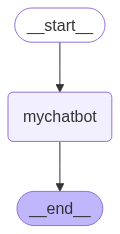

In [29]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In this workflow we can add the tools

In [30]:
input = {"messages":["Name all the european countries and arrnge in ascending based on military power"]}

In [31]:
app.invoke(input)

The question is : content='Name all the european countries and arrnge in ascending based on military power' additional_kwargs={} response_metadata={} id='6dc222d4-faaf-4d84-8010-e0847002c35e'


{'messages': [HumanMessage(content='Name all the european countries and arrnge in ascending based on military power', additional_kwargs={}, response_metadata={}, id='6dc222d4-faaf-4d84-8010-e0847002c35e'),
  HumanMessage(content="<think>\nOkay, so I need to list all the European countries and arrange them in ascending order based on military power. Hmm, where do I start? First, I should figure out what counts as a European country. I know some countries are partially in Asia, like Turkey and Russia, but I think they're often considered part of Europe for certain purposes. So I'll include them.\n\nNext, I need to define military power. It's not just the number of soldiers, right? It's also about the budget, technology, equipment, and maybe even alliances. I remember reading that the Global Firepower (GFP) rankings are a common source for this kind of data. They consider factors like military expenditure, active personnel, reserves, tanks, aircraft, naval strength, and more.\n\nSo, I sho

In [32]:
@tool

def search(query: str) -> str:
    """Searches the internet about the provided query."""
    if "delhi" in query.lower():
        return "The temperature is 45 degree Celsius in Delhi."
    return "the temperature is 25 degree and cloudy"

In [33]:
search.invoke("Temp in Delhi")

'The temperature is 45 degree Celsius in Delhi.'

In [34]:
tools = [search]

In [36]:
llm_withtool = llm_model.bind_tools(tools)

response = llm_withtool.invoke("what is the temperature in Delhi")

In [37]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'temperature in Delhi'},
  'id': 'eqfabwq82',
  'type': 'tool_call'}]

llm with tool call

In [41]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_withtool.invoke(question)
    return {"messages": [response]}

In [48]:
input = {"messages": ["what is the weather in Delhi"]}

In [49]:
response = call_model(input)

In [51]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '9h43e2pdz',
  'type': 'tool_call'}]

In [72]:
def router_function(state:MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [73]:
tools

[StructuredTool(name='search', description='Searches the internet about the provided query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002000DB7CA40>)]

In [74]:
tool_node = ToolNode(tools)

In [75]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='Searches the internet about the provided query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002000DB7CA40>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [76]:
workflow = StateGraph(MessagesState)

In [77]:
workflow.add_node("llm_withtool", call_model)
workflow.add_node("my_tools", tool_node)

In [78]:
workflow.add_edge(START, "llm_withtool")

workflow.add_conditional_edges("llm_withtool", router_function,
                               {"tools":"my_tools",
                                END:END})

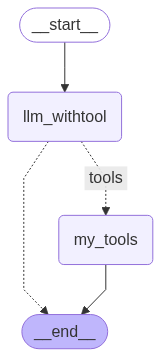

In [79]:
app2 = workflow.compile()

from IPython.display import Image, display

display(Image(app2.get_graph().draw_mermaid_png()))

In [80]:
app2.invoke({"messages": ["what is the weather in Delhi"]})

{'messages': [HumanMessage(content='what is the weather in Delhi', additional_kwargs={}, response_metadata={}, id='ac029098-d5f7-43bd-bc06-d36e2cce6af1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hh0ymnv1m', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 130, 'total_tokens': 247, 'completion_time': 0.504879995, 'prompt_time': 0.015311886, 'queue_time': 0.057202294, 'total_time': 0.520191881}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ce4ce046-f9e7-4eac-9876-963ded16ebb7-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'hh0ymnv1m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 117, 'total_tokens': 247}),
  ToolMessage(content='The temperature is 45 degree Celsius in Delhi

Looping

In [81]:
workflow.add_edge("my_tools", "llm_withtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [82]:
app3 = workflow.compile()

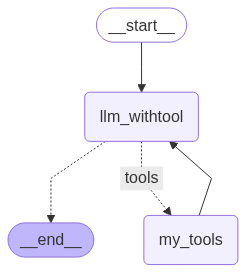

In [83]:
from IPython.display import Image, display

display(Image(app3.get_graph().draw_mermaid_png()))

In [85]:

for output in app3.stream({"messages": ["what is the weather in Delhi"]}):
    for key,value in output.items():
        print(f"here is the output for {key} : {value}")
        print(f"-----------------------------")
        print(value)
        print("\n")

here is the output for llm_withtool : {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's946h5qve', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 130, 'total_tokens': 247, 'completion_time': 0.510693835, 'prompt_time': 0.008337578, 'queue_time': 0.055337752000000004, 'total_time': 0.519031413}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9a56873-5b03-4da2-9e96-d4f9755aa73b-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 's946h5qve', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 117, 'total_tokens': 247})]}
-----------------------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's946h5qve', 'function': {'arguments': '{"query":"weathe

Configuring memory

In [86]:
"What is a weather in delhi can you tell me some good hotel for staying in north delhi"

'What is a weather in delhi can you tell me some good hotel for staying in north delhi'

In [87]:
from langgraph.checkpoint.memory import MemorySaver

In [88]:
memory = MemorySaver()

In [89]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("llm_withtool", call_model)

workflow3.add_node("my_tools", tool_node)

workflow3.add_edge(START, "llm_withtool")
workflow3.add_conditional_edges("llm_withtool", router_function,
                               {"tools":"my_tools",
                                END:END})

workflow3.add_edge("my_tools", "llm_withtool")

In [90]:
app4 = workflow3.compile(checkpointer=memory)

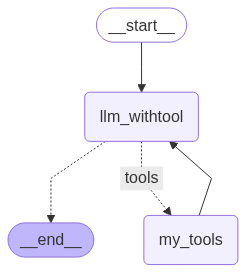

In [91]:
from IPython.display import Image, display

display(Image(app4.get_graph().draw_mermaid_png()))

In [92]:
config = {"configurable": {"thread_id": "1"}}

In [93]:
events =app4.stream({"messages": ["what is the weather in Delhi"]},config=config, stream_mode="values")

In [95]:
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (5xra7kmsk)
 Call ID: 5xra7kmsk
  Args:
    query: weather in Delhi
================================= Tool Message =================================
Name: search

The temperature is 45 degree Celsius in Delhi.
================================== Ai Message ==================================

The current temperature in Delhi is 45 degrees Celsius.


In [ ]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T05:57:12.067375+00:00',
 'id': '1f048e46-a3df-63d7-8003-13e286af5261',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.4163093423492825',
  'messages': '00000000000000000000000000000005.0.45889228527656845',
  'branch:to:llm_withtool': '00000000000000000000000000000005.0.572422930269936',
  'branch:to:my_tools': '00000000000000000000000000000004.0.6376272334396433'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.46281866190484167'},
  'llm_withtool': {'branch:to:llm_withtool': '00000000000000000000000000000004.0.897355736580897'},
  'my_tools': {'branch:to:my_tools': '00000000000000000000000000000003.0.5377151683986637'}},
 'channel_values': {'messages': [HumanMessage(content='what is the weather in Delhi', additional_kwargs={}, response_metadata={}, id='28a35b14-2d95-4038-bc97-01a8870666bc'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5xra7kmsk', 'function'

: 